# ReAct architecture for agents
- Pass tool output back to llm and let it reason on the output

In [5]:
## api key for tavily
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'ReAct-agents'

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel

In [3]:
## arxiv tool
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

## wiki tool
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

# tavily search tool
tavily = TavilySearchResults()

/var/folders/15/xbwr_x_d51sf0lj4mptglw6h0000gn/T/ipykernel_31989/427920356.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [6]:
# custom functions
def add(a:int, b:int)->int:
    ''' Adds a and b
    
    Parameters:
        a: first int
        b: second int
        
    Returns: 
        int
    '''
    return a+b

def subtract(a:int, b:int)->int:
    ''' Subtracts a and b
    
    Parameters:
        a: first int
        b: second int
        
    Returns: 
        int
    '''
    return a-b

def multiply(a:int, b:int)->int:
    ''' Multiplies a and b
    
    Parameters:
        a: first int
        b: second int
        
    Returns: 
        int
    '''
    return a*b

def divide(a:int, b:int)->float:
    ''' Adds a and b
    
    Parameters:
        a: first int
        b: second int
        
    Returns: 
        int
    '''
    return a/b if b>0 else float('inf')

# combine tools
tools = [arxiv, wiki, tavily, add, subtract, multiply, divide]

In [7]:
# initialise LLM model
from langchain_groq import ChatGroq
llm = ChatGroq(model = 'qwen/qwen3-32b')

# bind tools to llm
llm_with_tools = llm.bind_tools(tools)

In [8]:
# Create state schema
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from typing_extensions import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

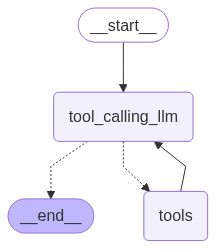

In [10]:
# Build the agent state graph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


## node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

## build graph
builder = StateGraph(State)
## add nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

## add edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition
)
builder.add_edge('tools', 'tool_calling_llm')

graph = builder.compile()


## display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from pprint import pprint
messages = graph.invoke({
    'messages': [HumanMessage(content='Find me top 10 AI news last month then find me papers on masked attention, explain what it is and then finally, solve this for me 2+2-3/2-10')]
})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find me top 10 AI news last month then find me papers on masked attention, explain what it is and then finally, solve this for me 2+2-3/2-10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1dj7x0cd3)
 Call ID: 1dj7x0cd3
  Args:
    query: top 10 AI news last month
  arxiv (96gazae7p)
 Call ID: 96gazae7p
  Args:
    query: masked attention
  divide (5e5j54dt7)
 Call ID: 5e5j54dt7
  Args:
    a: 3
    b: 2
  add (bqjewbpnc)
 Call ID: bqjewbpnc
  Args:
    a: 2
    b: 2
  subtract (fqhn5cn83)
 Call ID: fqhn5cn83
  Args:
    a: 4
    b: 1
  subtract (7v5h6m1wk)
 Call ID: 7v5h6m1wk
  Args:
    a: 3
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Artificial Intelligence News - ScienceDaily", "url": "https://www.sciencedaily.com/news/computers_math/ar

# Agent Memory
- Adding memory to our simple chatbot with ReAct architecture
## Can add memory using MemorySaver
- Langgraph uses a checkpointer to automatically save the graph state after each step
- The built-in persistence layer gives us memory, allowing langgraph to pick up from the last state update
- One of the easiest implementation of checkpointers is memorysaver, an in-memory key-value store for Graph State
- All we need to do is compile our graph with checkpointer, and our graph has memory

In [12]:
## node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

## build graph
builder = StateGraph(State)
## add nodes
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

## add edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition
)
builder.add_edge('tools', 'tool_calling_llm')

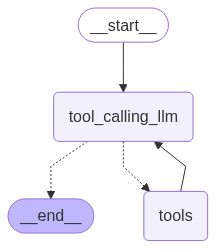

In [13]:
# compile graph wiht memory
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_w_memory = builder.compile(checkpointer=memory)

## display graph
display(Image(graph_w_memory.get_graph().draw_mermaid_png()))

In [17]:
## specify the thread
config = {'configurable': {'thread_id':'1'}}

# specify input
messages = [HumanMessage(content='Multiply that by .5')]
messages = graph_w_memory.invoke({'messages': messages}, config=config)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 12 and 13
================================== Ai Message ==================================
Tool Calls:
  add (y3z03hgf0)
 Call ID: y3z03hgf0
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

Add that number to -100
================================== Ai Message ==================================
Tool Calls:
  add (n1hycyxwn)
 Call ID: n1hycyxwn
  Args:
    a: 25
    b: -100
================================= Tool Message =================================
Name: add

-75
================================== Ai Message ==================================
Tool Calls:
  add (6g02shghp)
 Call ID: 6g02shghp
  Args:
    a: -75
    b: -100
===========